# Preference Learning Report Visualizations

Visualize the new simulation results JSON produced by `run_persona_linear_hx_xai_simulation` (HX-XAI vs AutoXAI baseline).

In [1]:
import matplotlib as mpl
from matplotlib.font_manager import FontProperties, findfont

FONT_FAMILY = "DejaVu Sans"

# Force a single concrete font file (prevents fallback differences)
FONT_PATH = findfont(FONT_FAMILY, fallback_to_default=True)
FP = FontProperties(fname=FONT_PATH)

mpl.rcParams.update({
    "font.family": FP.get_name(),   # keep rcParams consistent too
    "axes.unicode_minus": False,
})


from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']

DATASET_LABELS = {
    'open_compas': 'OpenML COMPAS',
    'openml_bank_marketing': 'OpenML Bank Marketing',
    'openml_german_credit': 'OpenML German Credit',
}
MODEL_LABELS = {
    'decision_tree': 'Decision Tree',
    'gradient_boosting': 'Gradient Boosting',
    'logistic_regression': 'Logistic Regression',
    'mlp_classifier': 'Multilayer Perceptron',
}

# Path to either a single simulation JSON or a directory containing multiple JSON files.
RESULTS_PATH = Path('../../results/hc_combo_20251228_050331/preference_learning_simulation_aligned/aut_xai_comp_all-metrics')
# Optional filters.
PERSONA_FILTER: str | None = None  # e.g. 'clinician' / 'regulator' / 'lay_user'
K_TO_PLOT = 3

def _suffix_from_path(path: Path) -> str:
    token = path.parent.name if path.suffix else path.name
    token = token or 'reports'
    return token.replace(' ', '_')

RUN_SUFFIX = _suffix_from_path(RESULTS_PATH)
REPORTS_DIR = (RESULTS_PATH.parent if RESULTS_PATH.suffix else RESULTS_PATH) / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')



In [2]:
def _iter_result_paths(path: Path) -> List[Path]:
    if path.is_dir():
        persona_jsons = list(path.rglob('persona_simulation_summary.json'))
        if persona_jsons:
            return sorted(persona_jsons)
        return sorted(path.rglob('*.json'))
    if path.is_file():
        return [path]
    return []


def load_simulation_results(path: Path = RESULTS_PATH) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for json_path in _iter_result_paths(path):
        payload: Dict[str, Any] = json.loads(json_path.read_text(encoding='utf-8'))
        dataset = payload.get('dataset')
        model = payload.get('model')
        persona = payload.get('persona')
        tau = (
            (payload.get('persona_sampling') or {}).get('tau_override')
            or (payload.get('persona_config') or {}).get('tau')
        )
        if tau is None:
            per_user = payload.get('per_user') or []
            if per_user and isinstance(per_user, list) and isinstance(per_user[0], dict):
                tau = per_user[0].get('tau')
        try:
            tau = float(tau) if tau is not None else None
        except Exception:
            tau = None

        for method, key in (
            ('PersoXAI', 'aggregate_top_k_mean'),
            ('autoxai', 'aggregate_autoxai_top_k_mean'),
        ):
            top_k = payload.get(key) or {}
            for k, stats in top_k.items():
                try:
                    k_int = int(k)
                except Exception:
                    continue
                spearman = 0.0
                if isinstance(stats, dict):
                    rank_corr = stats.get('rank_correlation')
                    if isinstance(rank_corr, dict):
                        spearman = float(rank_corr.get('spearman') or 0.0)
                    else:
                        spearman = float(stats.get('rank_correlation.spearman') or 0.0)
                records.append(
                    {
                        'file': json_path.name,
                        'dataset': dataset,
                        'model': model,
                        'persona': persona,
                        'tau': tau,
                        'method': method,
                        'k': k_int,
                        'precision': float((stats or {}).get('precision', 0.0)),
                        'recall': float((stats or {}).get('recall', 0.0)),
                        'jaccard': float((stats or {}).get('jaccard', 0.0)),
                        'spearman': spearman,
                    }
                )
    df = pd.DataFrame(records)
    if df.empty:
        print(f'No simulation results found under: {path.resolve()}')
        return df
    print(f'Loaded {len(df)} rows from {df["file"].nunique()} JSON file(s).')
    return df


results_df = load_simulation_results()
results_df.head()


Loaded 72 rows from 12 JSON file(s).


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,3,0.958750,0.958750,0.938125,0.837250
1,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,5,0.963000,0.963000,0.938452,0.928161
2,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,8,0.972031,0.972031,0.950389,0.961116
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,3,0.726250,0.726250,0.633250,0.374250
4,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,5,0.761750,0.761750,0.648348,0.505618


In [3]:
# Inspect encoded dataset sizes referenced by the simulation results.
ENCODED_BASE_DIR = Path('../../results') / 'hc_combo_20251228_050331' / 'encoded_pareto_fronts' / 'features_full_lm_stats'
encoded_paths_raw = []
for json_path in _iter_result_paths(RESULTS_PATH):
    payload = json.loads(json_path.read_text(encoding='utf-8'))
    encoded_path_val = payload.get('encoded_path')
    if encoded_path_val:
        encoded_paths_raw.append(encoded_path_val)

def _resolve_encoded_path(path_str: str) -> Path:
    path = Path(path_str)
    candidates = [
        path,
        Path.cwd() / path,
        RESULTS_PATH.parent / path,
        ENCODED_BASE_DIR / path.name,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return path

encoded_paths = sorted({str(_resolve_encoded_path(p)) for p in encoded_paths_raw})
encoded_stats_rows: list[dict[str, object]] = []
for raw_path in encoded_paths:
    resolved = Path(raw_path)
    exists = resolved.exists()
    rows = None
    cols = None
    error = None
    if exists:
        try:
            df = pd.read_parquet(resolved)
            rows = len(df)
            cols = len(df.columns)
        except Exception as exc:  # pragma: no cover - notebook debug helper
            error = str(exc)
    encoded_stats_rows.append(
        {
            'encoded_path': str(resolved),
            'exists': bool(exists),
            'rows': rows,
            'columns': cols,
            'error': error,
        }
    )

encoded_stats_df = pd.DataFrame(encoded_stats_rows)
print(f'Found {len(encoded_paths)} encoded file(s) referenced in results.')
encoded_stats_df


Found 12 encoded file(s) referenced in results.


,encoded_path,exists,rows,columns,error
0,../../results/hc_combo_20251228_050331/encoded...,True,1463,73,None
1,../../results/hc_combo_20251228_050331/encoded...,True,1488,73,None
2,../../results/hc_combo_20251228_050331/encoded...,True,1588,73,None
3,../../results/hc_combo_20251228_050331/encoded...,True,1616,73,None
4,../../results/hc_combo_20251228_050331/encoded...,True,914,73,None
5,../../results/hc_combo_20251228_050331/encoded...,True,1513,73,None
6,../../results/hc_combo_20251228_050331/encoded...,True,1675,73,None
7,../../results/hc_combo_20251228_050331/encoded...,True,1727,73,None
8,../../results/hc_combo_20251228_050331/encoded...,True,1187,73,None
9,../../results/hc_combo_20251228_050331/encoded...,True,1640,73,None


In [4]:
# Preview column names and example values from the first available encoded file.
if encoded_paths:
    preview_path = _resolve_encoded_path(encoded_paths[0])
else:
    preview_path = None

if preview_path and preview_path.exists():
    encoded_preview_df = pd.read_parquet(preview_path)
    print(f'Previewing encoded file: {preview_path}')
    print(f'Rows: {len(encoded_preview_df):,} | Columns: {len(encoded_preview_df.columns):,}')
    column_preview = pd.DataFrame(
        {
            'column': encoded_preview_df.columns,
            'example_value': encoded_preview_df.iloc[0].astype(str).tolist() if not encoded_preview_df.empty else [],
        }
    )
    display(column_preview.head(50))
    display(encoded_preview_df.head())
else:
    print('No encoded file available to preview (check RESULTS_PATH and encoded_path in results).')


Previewing encoded file: ../../results/hc_combo_20251228_050331/encoded_pareto_fronts/features_full_lm_stats/open_compas__decision_tree_pareto_encoded.parquet
Rows: 1,463 | Columns: 73


,column,example_value
0,dataset,open_compas
1,model,decision_tree
2,instance_index,61
3,method,causal_shap
4,method_variant,causal_shap__causal_shap_coalitions-20
5,dataset_id_oh_0,1
6,dataset_id_oh_1,0
7,dataset_id_oh_2,0
8,dataset_log_feature_count_z,-1.411888045039296
9,dataset_class_entropy_z,0.9657972281012779


,dataset,model,instance_index,method,method_variant,dataset_id_oh_0,dataset_id_oh_1,dataset_id_oh_2,dataset_log_feature_count_z,dataset_class_entropy_z,...,correctness,covariate_complexity,covariate_regularity,infidelity,monotonicity,non_sensitivity_delta_mean,non_sensitivity_safe_fraction,non_sensitivity_violation_fraction,non_sensitivity_zero_features,relative_input_stability
0,open_compas,decision_tree,61,causal_shap,causal_shap__causal_shap_coalitions-20,1,0,0,-1.411888,0.965797,...,1.080123,2.106633,2.106633,0.866376,-0.666667,-2.345208,2.345208,-2.345208,2.345208,1.059123
1,open_compas,decision_tree,61,integrated_gradients,integrated_gradients__ig_steps-40,1,0,0,-1.411888,0.965797,...,1.080123,2.106633,2.106633,0.866376,-0.666667,-2.345208,2.345208,-2.345208,2.345208,1.059123
2,open_compas,decision_tree,61,lime,lime__lime_kernel_width-1.5__lime_num_samples-50,1,0,0,-1.411888,0.965797,...,-0.925820,0.121705,0.121705,0.679405,-0.666667,0.426401,-0.426401,0.426401,-0.426401,-1.059909
3,open_compas,decision_tree,61,lime,lime__lime_kernel_width-1.5__lime_num_samples-100,1,0,0,-1.411888,0.965797,...,-0.925820,-1.132132,-1.132132,0.306566,-0.666667,0.426401,-0.426401,0.426401,-0.426401,0.632327
4,open_compas,decision_tree,61,lime,lime__lime_kernel_width-1.5__lime_num_samples-200,1,0,0,-1.411888,0.965797,...,-0.925820,0.212157,0.212157,0.523297,-0.666667,0.426401,-0.426401,0.426401,-0.426401,0.747543


In [5]:
def _format_label(name: object) -> str:
    if not isinstance(name, str) or not name:
        return 'Unknown'
    return name.replace('_', ' ').title()

if not results_df.empty:
    results_df['dataset_label'] = results_df['dataset'].map(DATASET_LABELS).fillna(results_df['dataset'].apply(_format_label))
    results_df['model_label'] = results_df['model'].map(MODEL_LABELS).fillna(results_df['model'].apply(_format_label))
    if PERSONA_FILTER is not None:
        results_df = results_df[results_df['persona'] == PERSONA_FILTER].copy()

plot_df = results_df[results_df['k'] == int(K_TO_PLOT)].copy() if not results_df.empty else results_df
plot_df.head()


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman,dataset_label,model_label
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,3,0.958750,0.958750,0.938125,0.837250,OpenML COMPAS,Decision Tree
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,3,0.726250,0.726250,0.633250,0.374250,OpenML COMPAS,Decision Tree
6,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,PersoXAI,3,0.959167,0.959167,0.938750,0.837750,OpenML COMPAS,Gradient Boosting
9,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,autoxai,3,0.693750,0.693750,0.594875,0.285321,OpenML COMPAS,Gradient Boosting
12,persona_simulation_summary__open_compas__logis...,open_compas,logistic_regression,auto-xai-persona,0.01,PersoXAI,3,0.950833,0.950833,0.926750,0.836500,OpenML COMPAS,Logistic Regression


In [6]:
summary_df = (
    plot_df
    .groupby(['dataset', 'dataset_label', 'model', 'model_label', 'persona', 'method', 'k'])
    [['precision', 'recall', 'jaccard']]
    .mean()
    .reset_index()
)
if not summary_df.empty:
    file_base = f"summary_all_datasets_all_models_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
    summary_df.to_csv(REPORTS_DIR / f"{file_base}.csv", index=False)
summary_df

,dataset,dataset_label,model,model_label,persona,method,k,precision,recall,jaccard
0,open_compas,OpenML COMPAS,decision_tree,Decision Tree,auto-xai-persona,PersoXAI,3,0.958750,0.958750,0.938125
1,open_compas,OpenML COMPAS,decision_tree,Decision Tree,auto-xai-persona,autoxai,3,0.726250,0.726250,0.633250
2,open_compas,OpenML COMPAS,gradient_boosting,Gradient Boosting,auto-xai-persona,PersoXAI,3,0.959167,0.959167,0.938750
3,open_compas,OpenML COMPAS,gradient_boosting,Gradient Boosting,auto-xai-persona,autoxai,3,0.693750,0.693750,0.594875
4,open_compas,OpenML COMPAS,logistic_regression,Logistic Regression,auto-xai-persona,PersoXAI,3,0.950833,0.950833,0.926750
5,open_compas,OpenML COMPAS,logistic_regression,Logistic Regression,auto-xai-persona,autoxai,3,0.780833,0.780833,0.705500
6,open_compas,OpenML COMPAS,mlp_classifier,Multilayer Perceptron,auto-xai-persona,PersoXAI,3,0.923750,0.923750,0.888000
7,open_compas,OpenML COMPAS,mlp_classifier,Multilayer Perceptron,auto-xai-persona,autoxai,3,0.707917,0.707917,0.620000
8,openml_bank_marketing,OpenML Bank Marketing,decision_tree,Decision Tree,auto-xai-persona,PersoXAI,3,0.937917,0.937917,0.908875
9,openml_bank_marketing,OpenML Bank Marketing,decision_tree,Decision Tree,auto-xai-persona,autoxai,3,0.728333,0.728333,0.648625


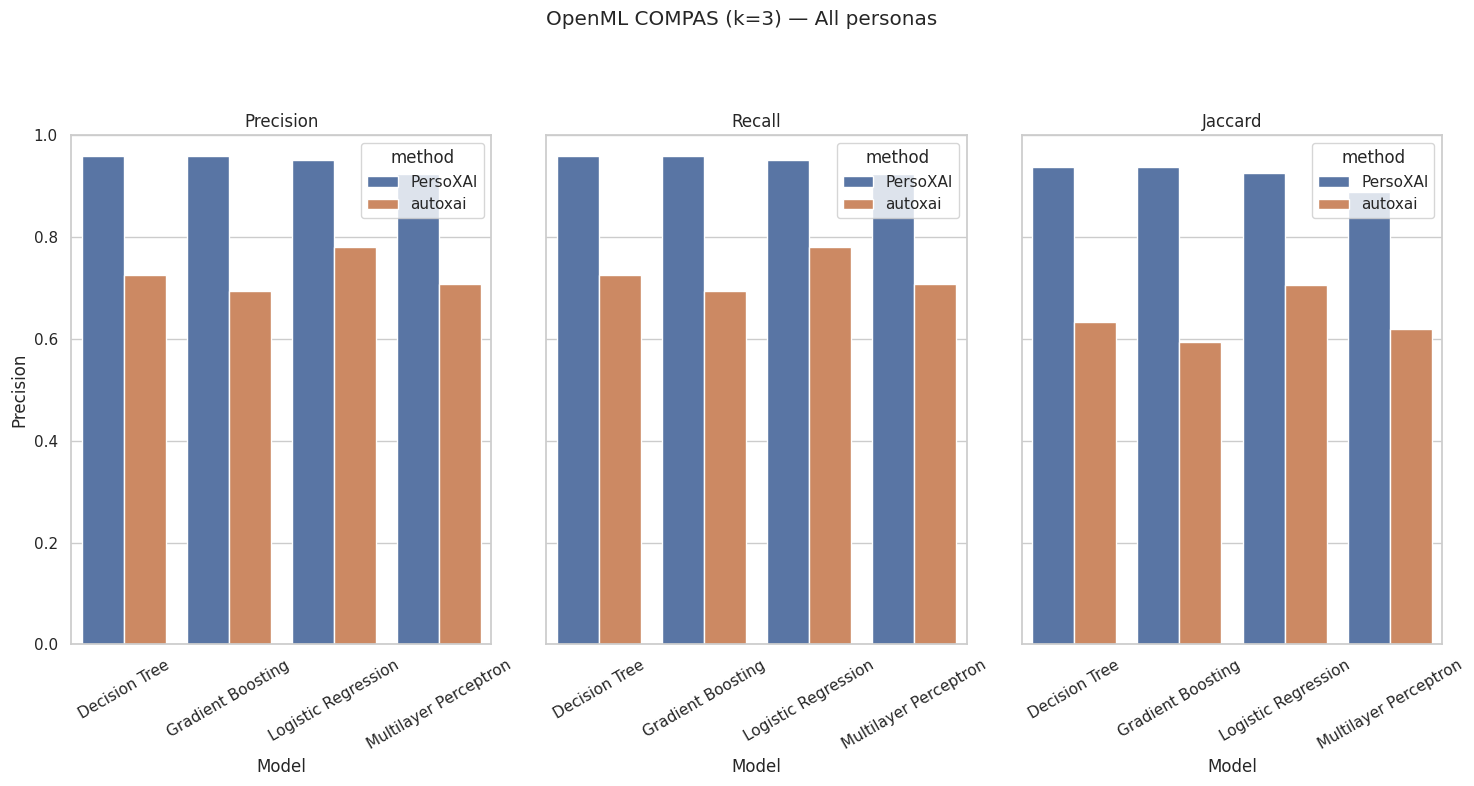

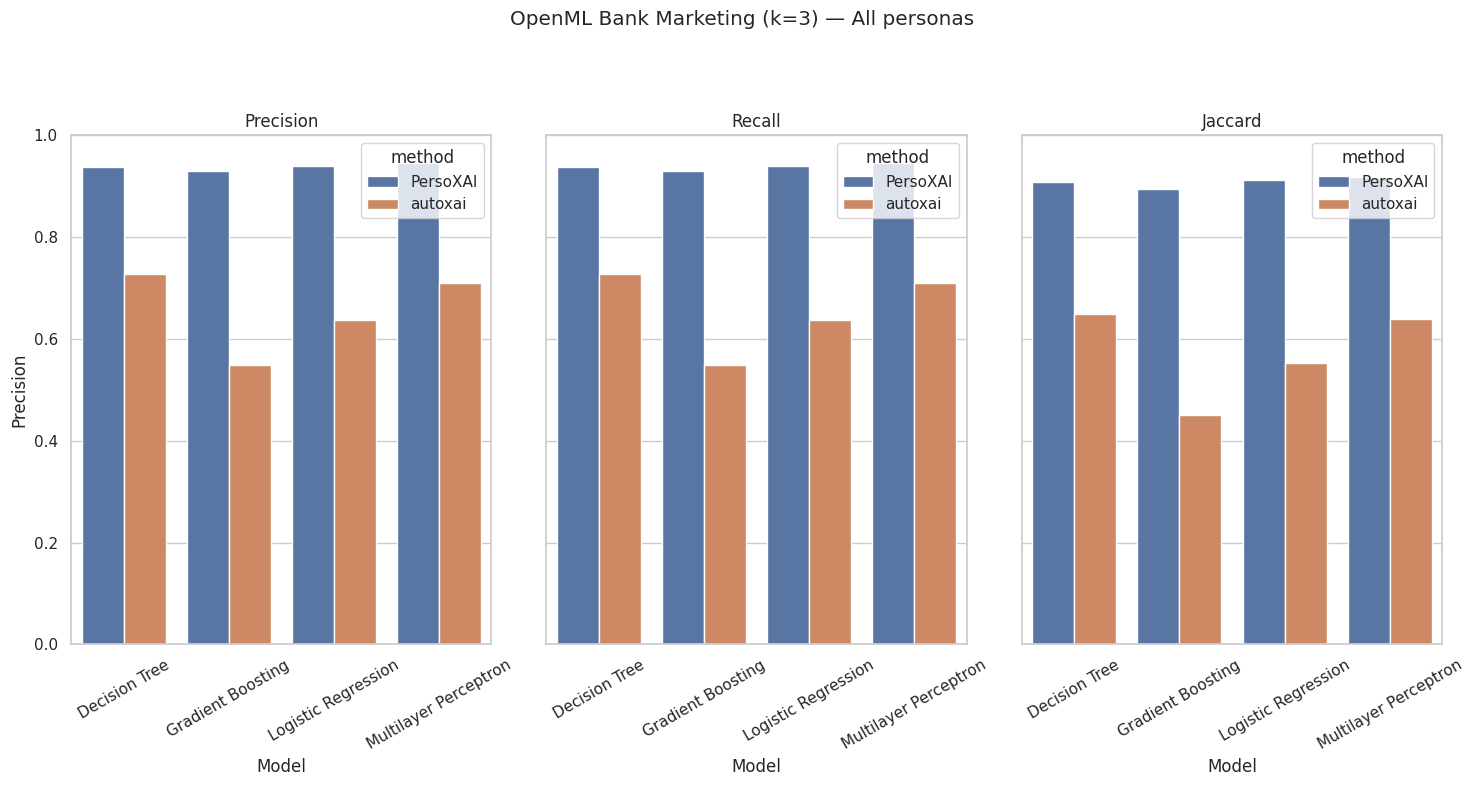

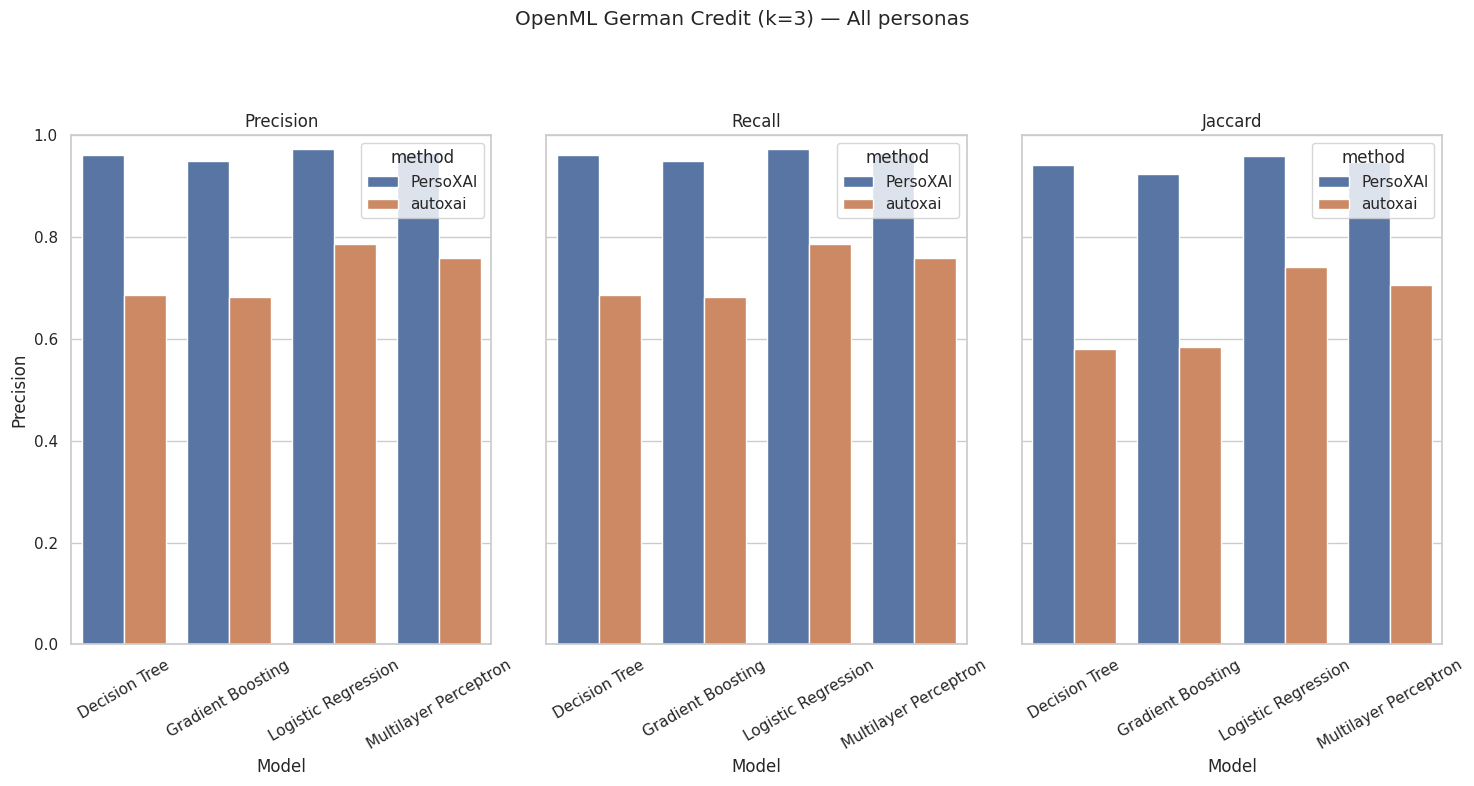

In [7]:
def plot_bars_by_dataset(df: pd.DataFrame) -> None:
    if df.empty:
        print('No rows to plot (check RESULTS_PATH / PERSONA_FILTER / K_TO_PLOT).')
        return

    model_order = [MODEL_LABELS[key] for key in MODEL_LABELS if (df['model'] == key).any()]
    for dataset_key, subset in df.groupby('dataset', sort=True):
        dataset_label = subset['dataset_label'].iloc[0]
        fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
        for ax, metric in zip(axes, ['precision', 'recall', 'jaccard']):
            sns.barplot(
                data=subset,
                x='model_label',
                y=metric,
                hue='method',
                order=model_order if model_order else None,
                ax=ax,
            )
            ax.set_title(metric.title())
            ax.set_xlabel('Model')
            ax.set_ylabel(metric.title())
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', rotation=30)
        persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
        fig.suptitle(f'{dataset_label} (k={int(K_TO_PLOT)}) — {persona_title}')
        fig.tight_layout(rect=[0, 0, 1, 0.92])
        file_base = f"bars_{dataset_key}_all_models_precision_recall_jaccard_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
        fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
        fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
        plt.show()
        plt.close(fig)


plot_bars_by_dataset(summary_df)



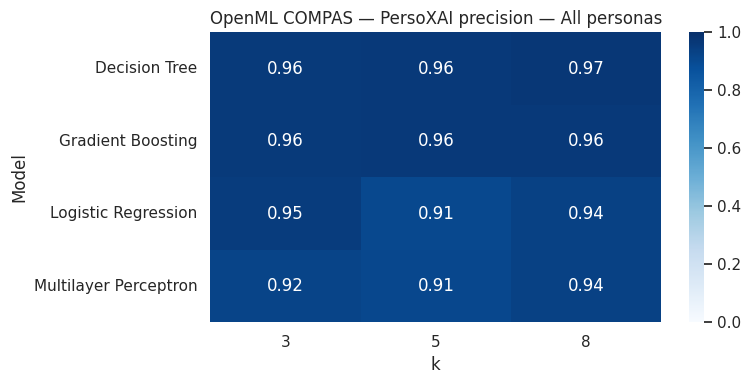

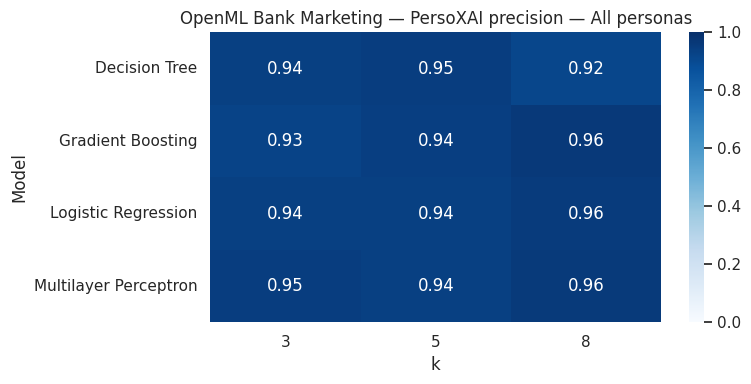

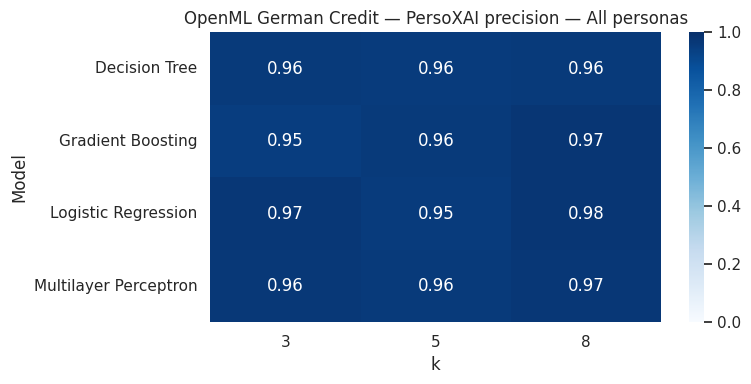

In [8]:
HEATMAP_METHOD = 'PersoXAI'  # 'hx_xai' or 'autoxai'
HEATMAP_METRIC = 'precision'  # 'precision' / 'recall' / 'jaccard'

heatmap_source = results_df.copy()
if PERSONA_FILTER is not None and not heatmap_source.empty:
    heatmap_source = heatmap_source[heatmap_source['persona'] == PERSONA_FILTER].copy()
if not heatmap_source.empty:
    heatmap_source['dataset_label'] = heatmap_source['dataset'].map(DATASET_LABELS).fillna(heatmap_source['dataset'].apply(_format_label))
    heatmap_source['model_label'] = heatmap_source['model'].map(MODEL_LABELS).fillna(heatmap_source['model'].apply(_format_label))

for dataset_key, subset in heatmap_source[heatmap_source['method'] == HEATMAP_METHOD].groupby('dataset', sort=True):
    dataset_label = subset['dataset_label'].iloc[0]
    pivot = subset.pivot_table(index='model_label', columns='k', values=HEATMAP_METRIC, aggfunc='mean')
    if pivot.empty:
        continue
    pivot = pivot.reindex(columns=sorted(pivot.columns))
    fig, ax = plt.subplots(figsize=(8, max(4, 0.6 * len(pivot))))
    sns.heatmap(pivot, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='Blues', ax=ax)
    persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
    ax.set_title(f'{dataset_label} — {HEATMAP_METHOD} {HEATMAP_METRIC} — {persona_title}')
    ax.set_xlabel('k')
    ax.set_ylabel('Model')
    fig.tight_layout()
    file_base = f"heatmap_{dataset_key}_all_models_{HEATMAP_METHOD}_{HEATMAP_METRIC}_{RUN_SUFFIX}"
    fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    pivot.to_csv(REPORTS_DIR / f"{file_base}.csv")
    plt.show()
    plt.close(fig)

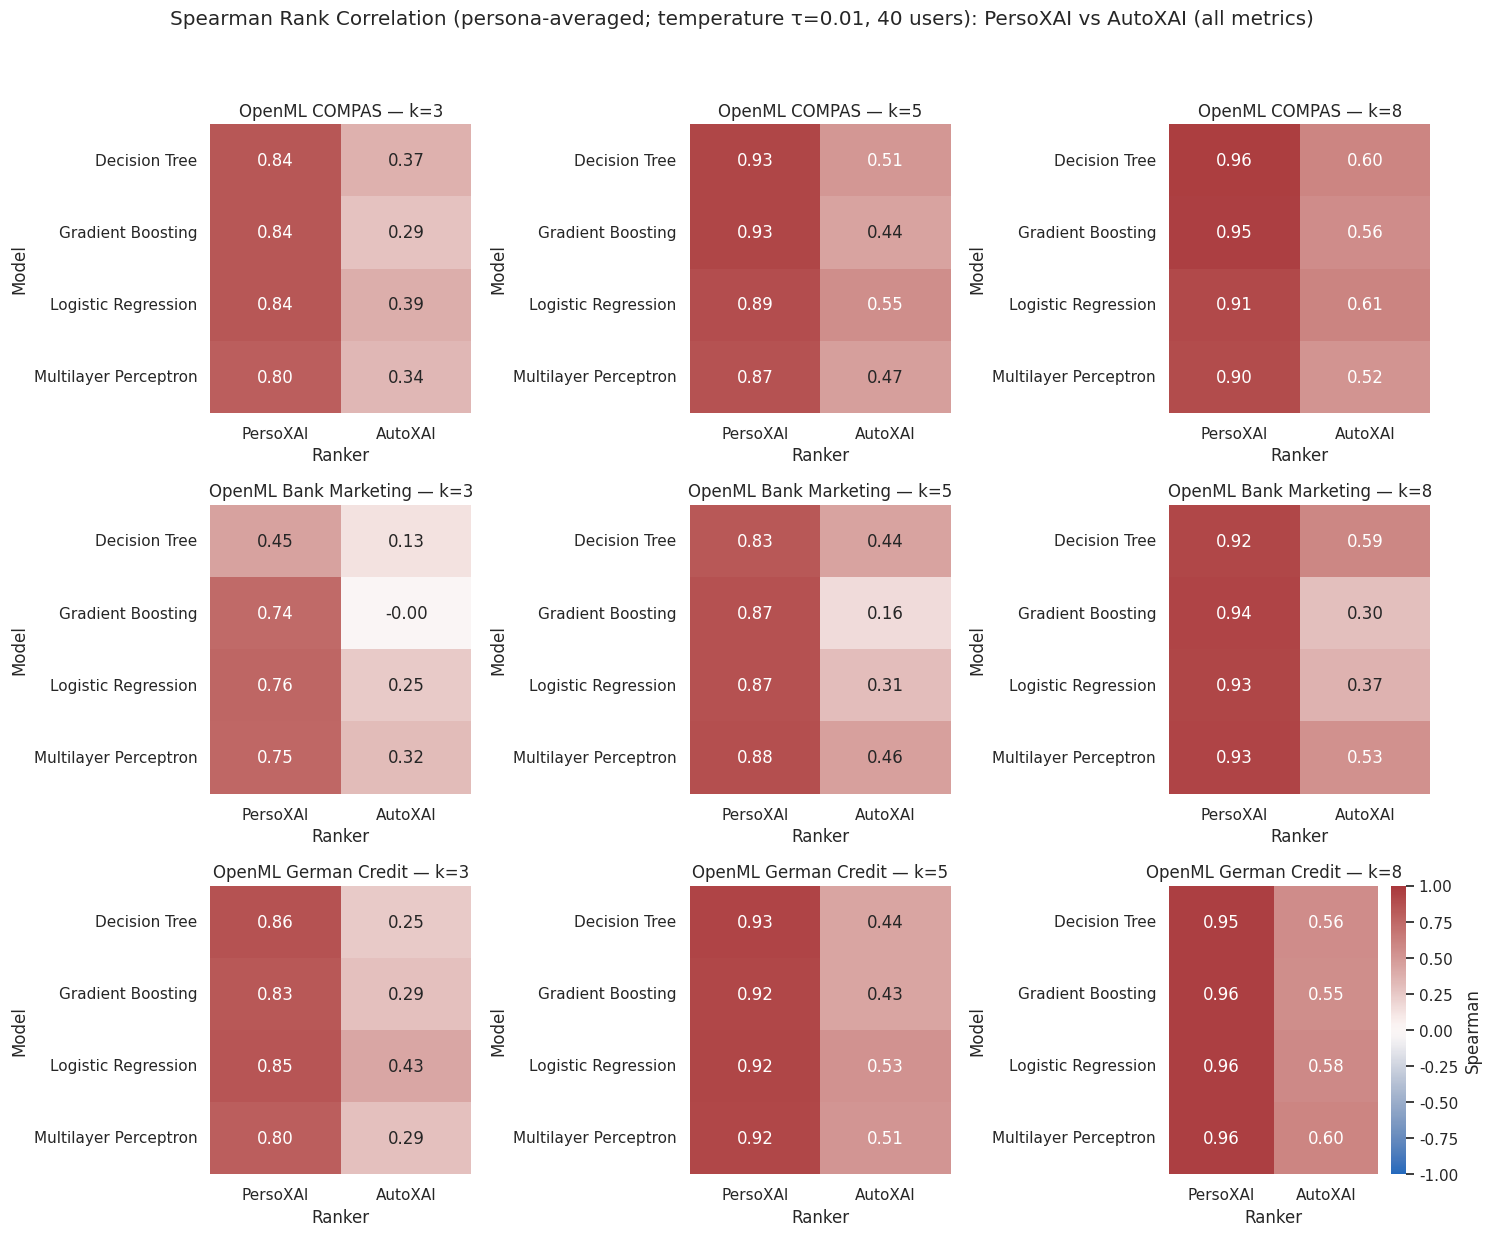

In [9]:
# Spearman heatmaps (persona-averaged): HX-XAI (Ours) vs AutoXAI

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

ranker_labels = {
    'perso_xai': 'PersoXAI',
    'autoxai': 'AutoXAI',
}

spearman_source = results_df.copy()
if spearman_source.empty:
    print('No results loaded (check RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    n_rows = len(datasets)
    n_cols = len(K_VALUES)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.2 * n_rows), squeeze=False)
    fig.subplots_adjust(right=0.88, bottom=0.10, top=0.90, wspace=0.35, hspace=0.35)
    for row_idx, dataset_key in enumerate(datasets):
        dataset_label = DATASET_LABELS.get(dataset_key, _format_label(dataset_key))
        for col_idx, k in enumerate(K_VALUES):
            ax = axes[row_idx][col_idx]
            subset = spearman_df[(spearman_df['dataset'] == dataset_key) & (spearman_df['k'] == int(k))].copy()
            if subset.empty:
                ax.axis('off')
                continue

            pivot_table = (
                subset
                .pivot_table(index='model_label', columns='method', values='spearman', aggfunc='mean')
                .rename(columns=ranker_labels)
            )

            desired_cols = [ranker_labels['perso_xai'], ranker_labels['autoxai']]
            pivot_table = pivot_table.reindex(columns=[c for c in desired_cols if c in pivot_table.columns])

            present_models = set(subset['model'])
            model_order = [
                MODEL_LABELS.get(model_key, _format_label(model_key))
                for model_key in MODEL_LABELS
                if model_key in present_models
            ]
            if model_order:
                pivot_table = pivot_table.reindex(model_order)

            mask = pivot_table.isna()
            sns.heatmap(
                pivot_table,
                annot=True,
                fmt='.2f',
                cmap='vlag',
                vmin=-1,
                vmax=1,
                mask=mask,
                ax=ax,
                cbar=(row_idx == n_rows - 1 and col_idx == n_cols - 1),
                cbar_kws={'label': 'Spearman'} if (row_idx == n_rows - 1 and col_idx == n_cols - 1) else None,
            )
            ax.set_title(f"{dataset_label} — k={k}")
            ax.set_xlabel('Ranker')
            ax.set_ylabel('Model')

    fig.suptitle(
        f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): "
        f"{ranker_labels['perso_xai']} vs {ranker_labels['autoxai']} (all metrics)"
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    spearman_fig = REPORTS_DIR / f"spearman_heatmaps_all_datasets_all_models_{RUN_SUFFIX}.png"
    fig.savefig(spearman_fig, dpi=300, bbox_inches='tight')
    spearman_fig = REPORTS_DIR / f"spearman_heatmaps_all_datasets_all_models_{RUN_SUFFIX}.pdf"
    fig.savefig(spearman_fig, dpi=300, bbox_inches='tight', format='pdf')
    spearman_df.to_csv(REPORTS_DIR / f"spearman_heatmap_values_all_datasets_all_models_{RUN_SUFFIX}.csv", index=False)
    plt.show()
    plt.close(fig)



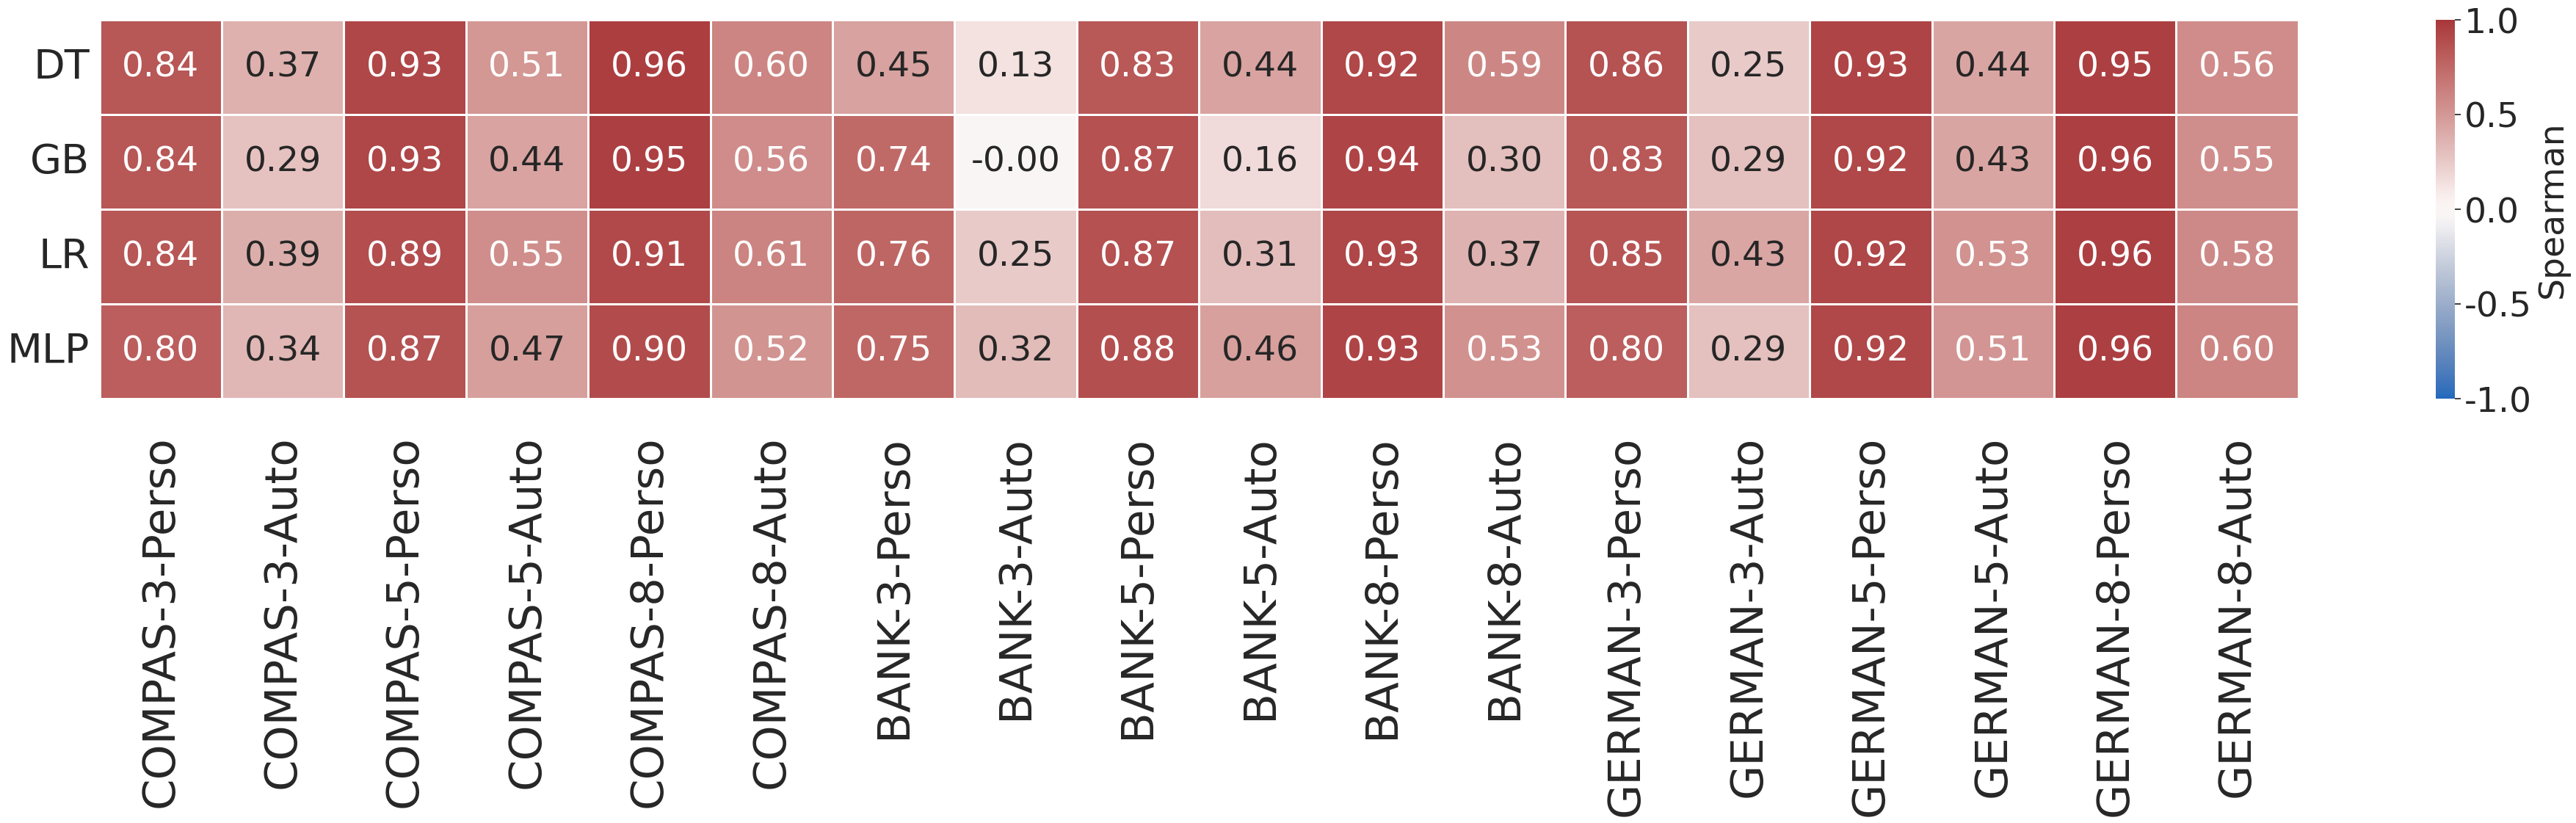

In [ ]:
# --- Compact single-heatmap version (two subcolumns per dataset×k) ---
from matplotlib.gridspec import GridSpec

FONT_FAMILY = "DejaVu Sans"
K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

ranker_labels = {
    'perso_xai': 'PersoXAI',
    'autoxai': 'AutoXAI',
}

# Short labels for compact x-axis (customize as you like)
DATASET_SHORT = {
    'open_compas': 'COMPAS',
    'openml_bank_marketing': 'BANK',
    'openml_german_credit': 'GERMAN',
}

# model_labels 

MODEL_LABELS = {
    'decision_tree': 'DT',
    'gradient_boosting': 'GB',
    'logistic_regression': 'LR',
    'mlp_classifier': 'MLP',
}

spearman_source = results_df.copy()
if spearman_source.empty:
    print('No results loaded (check RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    # Temperature title logic (unchanged)
    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    # Datasets to include (preserve your preferred order)
    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    # --- Build a single wide table: rows=models, cols=(dataset,k,method) ---
    wide = (
        spearman_df
        .pivot_table(
            index='model_label',
            columns=['dataset', 'k', 'method'],
            values='spearman',
            aggfunc='mean'
        )
    )

    # Keep only the two methods and rename them
    wide = wide.rename(columns=ranker_labels, level=2)
    keep_methods = [ranker_labels['perso_xai'], ranker_labels['autoxai']]
    wide = wide.loc[:, wide.columns.get_level_values(2).isin(keep_methods)]

    # Enforce column order: dataset order × K order × (Perso, Auto)
    ordered_cols = []
    for d in datasets:
        for k in K_VALUES:
            for m in keep_methods:
                col = (d, int(k), m)
                if col in wide.columns:
                    ordered_cols.append(col)
    wide = wide.reindex(columns=pd.MultiIndex.from_tuples(ordered_cols, names=wide.columns.names))

    # Enforce model order (same idea as your original)
    present_models = set(spearman_df['model'])
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if model_key in present_models
    ]
    if model_order:
        wide = wide.reindex(model_order)

    # Flatten column names into compact strings
    def _col_label(d, k, m):
        d_short = DATASET_SHORT.get(d, DATASET_LABELS.get(d, _format_label(d)))
        m_short = 'Perso' if m == ranker_labels['perso_xai'] else 'Auto'
        return f"{d_short}-{k}-{m_short}"

    wide.columns = [_col_label(d, k, m) for (d, k, m) in wide.columns]

    # --- Plot ---
    ncols = wide.shape[1]
    nrows = wide.shape[0]

    # A reasonable compact sizing rule; tweak if you want it tighter/looser
    # fig_w = min(24, 23.80 * ncols)   # was 0.45
    # fig_h = min(10.4, 2.0 * nrows)

    fig_w = 3.20 * ncols   # was 0.45
    fig_h = 3.0 * nrows
    # fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    extra_bottom = 5.0   # controls space for x-ticks (in inches)
    heatmap_height = fig_h

    fig = plt.figure(figsize=(fig_w, heatmap_height + extra_bottom))
    gs = GridSpec(
        2, 1,
        height_ratios=[heatmap_height, extra_bottom],
        hspace=0.0
    )

    ax = fig.add_subplot(gs[0])
    # fig, ax = plt.subplots(figsize=(12, 8))
    
    mask = wide.isna()
    sns.heatmap(
    wide,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    vmin=-1,
    vmax=1,
    mask=mask,
    cbar=True,
    cbar_kws={'label': 'Spearman'},
    ax=ax,

    # ✅ readability fixes
    linewidths=0.8,
    linecolor='white',
    annot_kws={'fontsize': 34,},   # try 8 if still cramped
)
    
    cbar = ax.collections[0].colorbar
    cbar.set_label("Spearman", fontsize=34)
    cbar.ax.tick_params(labelsize=34)


    ax.set_xlabel('')
    ax.set_ylabel('')

    # Make x labels like your compact example
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='center',
    fontsize=44,
    fontfamily=FONT_FAMILY
    )

    ax.tick_params(axis='x', pad=30)  # ← THIS is what you want
    
    ax.set_yticklabels(ax.get_yticklabels(), 
                       rotation=0, 
                       fontsize=44, 
                       fontfamily=FONT_FAMILY)

    fig.subplots_adjust(left=0.25, bottom=0.45)

    # Optional: draw separators between each (dataset,k) condition (every 2 columns)
    for x in range(2, ncols, 2):
        ax.axvline(x, color='white', linewidth=2)

    # ax.set_title(
    #     f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): "
    #     f"{ranker_labels['perso_xai']} vs {ranker_labels['autoxai']} (all metrics)"
    # )

    # fig.tight_layout()

    spearman_fig = REPORTS_DIR / f"spearman_heatmap_compact_all_datasets_all_models_{RUN_SUFFIX}.png"
    fig.savefig(spearman_fig, dpi=500, bbox_inches='tight')
    spearman_fig = REPORTS_DIR / f"spearman_heatmap_compact_all_datasets_all_models_{RUN_SUFFIX}.pdf"
    fig.savefig(spearman_fig, dpi=500, bbox_inches='tight', format='pdf')

    # Save the compact matrix too (easy to read back)
    wide.to_csv(REPORTS_DIR / f"spearman_heatmap_compact_values_{RUN_SUFFIX}.csv")

    plt.show()
    plt.close(fig)


In [11]:
# Tau sweep summary: plot τ vs aggregated Spearman.
# Point this to the folder/file produced by `python -m src.preference_learning.run_all --tau-values ...`.

# Common locations:
# - (RESULTS_PATH)/tau_tuning/tau_tunning_summary.json  (if you ran with --tau-results-dir under RESULTS_PATH)
# - ../../preference-learning-simulation/basic-features/tau-tunning-results/tau_tunning_summary.json (default)


# TAU_SWEEP_RESULTS_PATH = Path('../../results') / 'full_run_dec8' / 'preference_learning_simulation' / 'basic_features/' / 'untuned-svc' / 'tau_tunning'

# def _find_tau_sweep_summary(path: Path) -> Path | None:
#     candidates = [path, TAU_SWEEP_RESULTS_PATH]
#     for base in candidates:
#         if base.is_dir():
#             for name in ('tau_tunning_summary.json', 'tau_tunning_summary.csv'):
#                 candidate = base / name
#                 if candidate.exists():
#                     return candidate
#         elif base.is_file() and base.name in {'tau_tunning_summary.json', 'tau_tunning_summary.csv'}:
#             return base

#     search_root = path if path.is_dir() else path.parent
#     hits = list(search_root.rglob('tau_tunning_summary.json'))
#     return hits[0] if hits else None


# summary_path = _find_tau_sweep_summary(TAU_SWEEP_RESULTS_PATH)
# if summary_path is None:
#     print('No tau sweep summary found. Update TAU_SWEEP_RESULTS_PATH or FALLBACK_TAU_SWEEP_RESULTS_PATH.')
# else:
#     if summary_path.suffix == '.csv':
#         tau_summary_df = pd.read_csv(summary_path)
#         best_tau = float(tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['tau'])
#         best_value = float(tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['aggregate_spearman'])
#     else:
#         payload = json.loads(summary_path.read_text(encoding='utf-8'))
#         tau_summary_df = pd.DataFrame(payload.get('results') or [])
#         best_tau = float(payload.get('best_tau')) if payload.get('best_tau') is not None else float('nan')
#         best_value = float(payload.get('best_aggregate_spearman')) if payload.get('best_aggregate_spearman') is not None else float('nan')
#         if pd.isna(best_tau) and not tau_summary_df.empty:
#             best_row = tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]
#             best_tau = float(best_row['tau'])
#             best_value = float(best_row['aggregate_spearman'])

#     if tau_summary_df.empty:
#         print(f'No tau sweep rows found in: {summary_path}')
#     else:
#         tau_summary_df = tau_summary_df.copy()
#         tau_summary_df['tau'] = pd.to_numeric(tau_summary_df['tau'], errors='coerce')
#         tau_summary_df['aggregate_spearman'] = pd.to_numeric(tau_summary_df['aggregate_spearman'], errors='coerce')
#         tau_summary_df = tau_summary_df.dropna(subset=['tau', 'aggregate_spearman']).sort_values('tau')
#         display(tau_summary_df)

#         fig, ax = plt.subplots(figsize=(12, 8))
#         sns.lineplot(data=tau_summary_df, x='tau', y='aggregate_spearman', marker='o', ax=ax)
#         if not pd.isna(best_tau):
#             ax.axvline(best_tau, color='tab:red', linestyle='--', linewidth=1, alpha=0.6)
#             ax.scatter([best_tau], [best_value], color='tab:red', zorder=5)
#             ax.annotate(
#                 f'best τ={best_tau:g}\nSpearman={best_value:.3f}',
#                 xy=(best_tau, best_value),
#                 xycoords='data',
#                 xytext=(0.6, 0.90),
#                 textcoords='axes fraction',
#                 ha='right',
#                 va='top',
#                 arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'alpha': 0.6},
#                 bbox={'boxstyle': 'round,pad=0.25', 'fc': 'white', 'ec': '0.8', 'alpha': 0.9},
#             )

#         ax.set_title('Effect of preference temperature τ on aggregated Spearman')
#         ax.set_xlabel('τ (temperature)')
#         ax.set_ylabel('Aggregated Spearman (mean across runs and k)')
#         ax.grid(True, which='both', axis='both', alpha=0.2)
#         fig.tight_layout()

#         out_base = f'tau_sweep_spearman_{RUN_SUFFIX}'
#         fig.savefig(REPORTS_DIR / f'{out_base}.png', dpi=300, bbox_inches='tight')
#         tau_summary_df.to_csv(REPORTS_DIR / f'{out_base}.csv', index=False)
#         plt.show()
#         plt.close(fig)


In [12]:
# Num-users sweep summary: plot num_users vs aggregated Spearman.
# Point this to the folder/file produced by `python -m src.preference_learning.run_all --num-users-values ...`.

# Common locations:
# - (RESULTS_PATH)/num_users_sweep/num_users_sweep_summary.json  (if you ran with --num-users-results-dir under RESULTS_PATH)
# - ../../preference-learning-simulation/basic-features/num-users-sweep-results/num_users_sweep_summary.json (default)


# NUM_USERS_SWEEP_RESULTS_PATH = (
#     Path('../../results')
#     / 'full_run_dec8'
#     / 'preference_learning_simulation'
#     / 'basic_features/'
#     / 'untuned-svc'
#     / 'num_users_sweep'
# )


# def _find_num_users_sweep_summary(path: Path) -> Path | None:
#     candidates = [path, NUM_USERS_SWEEP_RESULTS_PATH]
#     for base in candidates:
#         if base.is_dir():
#             for name in ('num_users_sweep_summary.json', 'num_users_sweep_summary.csv'):
#                 candidate = base / name
#                 if candidate.exists():
#                     return candidate
#         elif base.is_file() and base.name in {'num_users_sweep_summary.json', 'num_users_sweep_summary.csv'}:
#             return base

#     search_root = path if path.is_dir() else path.parent
#     hits = list(search_root.rglob('num_users_sweep_summary.json'))
#     return hits[0] if hits else None


# summary_path = _find_num_users_sweep_summary(NUM_USERS_SWEEP_RESULTS_PATH)
# if summary_path is None:
#     print('No num-users sweep summary found. Update NUM_USERS_SWEEP_RESULTS_PATH.')
# else:
#     if summary_path.suffix == '.csv':
#         num_users_summary_df = pd.read_csv(summary_path)
#         best_num_users = int(
#             num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['num_users']
#         )
#         best_value = float(
#             num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['aggregate_spearman']
#         )
#     else:
#         payload = json.loads(summary_path.read_text(encoding='utf-8'))
#         num_users_summary_df = pd.DataFrame(payload.get('results') or [])
#         best_num_users = (
#             int(payload.get('best_num_users'))
#             if payload.get('best_num_users') is not None
#             else -1
#         )
#         best_value = (
#             float(payload.get('best_aggregate_spearman'))
#             if payload.get('best_aggregate_spearman') is not None
#             else float('nan')
#         )
#         if best_num_users < 0 and not num_users_summary_df.empty:
#             best_row = num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]
#             best_num_users = int(best_row['num_users'])
#             best_value = float(best_row['aggregate_spearman'])

#     if num_users_summary_df.empty:
#         print(f'No num-users sweep rows found in: {summary_path}')
#     else:
#         num_users_summary_df = num_users_summary_df.copy()
#         num_users_summary_df['num_users'] = pd.to_numeric(num_users_summary_df['num_users'], errors='coerce')
#         num_users_summary_df['aggregate_spearman'] = pd.to_numeric(
#             num_users_summary_df['aggregate_spearman'], errors='coerce'
#         )
#         num_users_summary_df = (
#             num_users_summary_df.dropna(subset=['num_users', 'aggregate_spearman'])
#             .sort_values('num_users')
#         )
#         display(num_users_summary_df)

#         fig, ax = plt.subplots(figsize=(12, 8))
#         sns.lineplot(data=num_users_summary_df, x='num_users', y='aggregate_spearman', marker='o', ax=ax)
#         if best_num_users >= 1 and not pd.isna(best_value):
#             ax.axvline(best_num_users, color='tab:red', linestyle='--', linewidth=1, alpha=0.6)
#             ax.scatter([best_num_users], [best_value], color='tab:red', zorder=5)
#             ax.annotate(
#                 f'best users={best_num_users}\nSpearman={best_value:.3f}',
#                 xy=(best_num_users, best_value),
#                 xycoords='data',
#                 xytext=(0.6, 0.90),
#                 textcoords='axes fraction',
#                 ha='right',
#                 va='top',
#                 arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'alpha': 0.6},
#                 bbox={'boxstyle': 'round,pad=0.25', 'fc': 'white', 'ec': '0.8', 'alpha': 0.9},
#             )

#         ax.set_title('Effect of number of users on aggregated Spearman')
#         ax.set_xlabel('num_users')
#         ax.set_ylabel('Aggregated Spearman (mean across runs and k)')
#         ax.grid(True, which='both', axis='both', alpha=0.2)
#         fig.tight_layout()

#         out_base = f'num_users_sweep_spearman_{RUN_SUFFIX}'
#         fig.savefig(REPORTS_DIR / f'{out_base}.png', dpi=300, bbox_inches='tight')
#         num_users_summary_df.to_csv(REPORTS_DIR / f'{out_base}.csv', index=False)
#         plt.show()
#         plt.close(fig)


Loaded 144 rows from 48 JSON file(s).


/tmp/ipykernel_8398/3088575171.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = spearman_df.pivot_table(


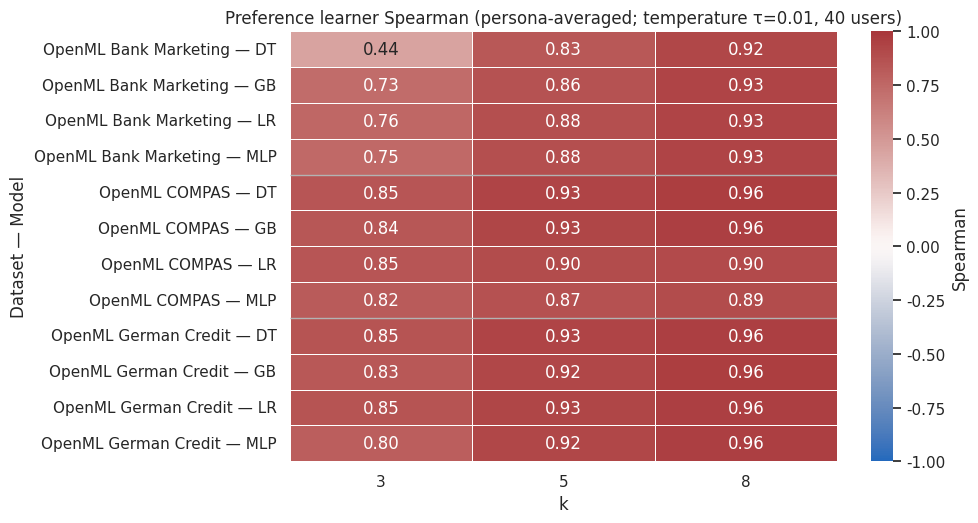

In [13]:
# Spearman heatmap (persona-averaged): preference learner only (all personas)
# Combined into a single heatmap since there's only one ranker.

PREFERENCE_ONLY_RESULTS_PATH = Path(
    '../../results/hc_combo_20251228_050331/preference_learning_simulation_aligned/preference_only_all_personas'
)
PREFERENCE_ONLY_RUN_SUFFIX = _suffix_from_path(PREFERENCE_ONLY_RESULTS_PATH)
PREFERENCE_ONLY_REPORTS_DIR = (
    (PREFERENCE_ONLY_RESULTS_PATH.parent if PREFERENCE_ONLY_RESULTS_PATH.suffix else PREFERENCE_ONLY_RESULTS_PATH)
    / 'reports'
)
PREFERENCE_ONLY_REPORTS_DIR.mkdir(parents=True, exist_ok=True)

preference_only_results_df = load_simulation_results(PREFERENCE_ONLY_RESULTS_PATH)
if not preference_only_results_df.empty:
    preference_only_results_df = preference_only_results_df[
        preference_only_results_df['method'] == 'PersoXAI'
    ].copy()

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

spearman_source = preference_only_results_df.copy()
if spearman_source.empty:
    print('No preference-only results loaded (check PREFERENCE_ONLY_RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    # Build a single (dataset, model) x k table.
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if (spearman_df['model'] == model_key).any()
    ]

    spearman_df['dataset'] = pd.Categorical(spearman_df['dataset'], categories=datasets, ordered=True)
    if model_order:
        spearman_df['model_label'] = pd.Categorical(spearman_df['model_label'], categories=model_order, ordered=True)

    pivot = spearman_df.pivot_table(
        index=['dataset_label', 'model_label'],
        columns='k',
        values='spearman',
        aggfunc='mean',
    ).reindex(columns=K_VALUES)

    # Flatten the MultiIndex for compact y tick labels.
    yticklabels = [f"{ds} — {model}" for ds, model in pivot.index]

    n_rows = len(pivot)
    fig_h = max(4.5, 0.45 * n_rows)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap='vlag',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Spearman'},
        ax=ax,
    )
    ax.set_yticklabels(yticklabels, rotation=0)
    ax.set_xlabel('k')
    ax.set_ylabel('Dataset — Model')

    # Add separators between datasets.
    if hasattr(pivot.index, 'levels') and len(pivot.index.levels) == 2:
        counts_by_dataset = (
            pivot.reset_index()[['dataset_label', 'model_label']]
            .groupby('dataset_label', sort=False)
            .size()
            .tolist()
        )
        offset = 0
        for count in counts_by_dataset[:-1]:
            offset += count
            ax.hlines(offset, *ax.get_xlim(), colors='0.7', linewidth=1.0)

    ax.set_title(
        f"Preference learner Spearman (persona-averaged; temperature {temperature_title}, 40 users)"
    )
    fig.tight_layout()

    out_base = f"spearman_heatmap_preference_only_combined_{PREFERENCE_ONLY_RUN_SUFFIX}"
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    pivot.reset_index().to_csv(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.csv", index=False)
    plt.show()
    plt.close(fig)


/tmp/ipykernel_8398/656371118.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("model_label")["spearman"]
/tmp/ipykernel_8398/656371118.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("model_label")["spearman"]
/tmp/ipykernel_8398/656371118.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("model_label")["spearman"]
/tmp/ipykernel_8398/656371118.py:45: FutureWarnin

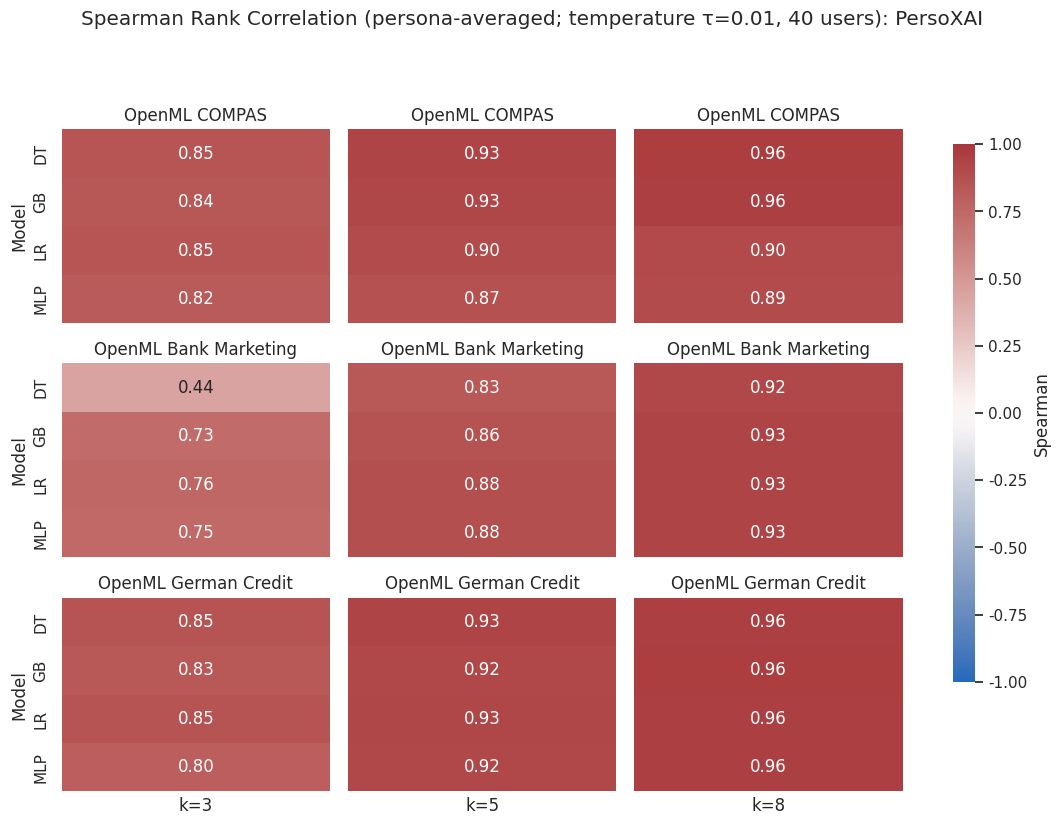

In [14]:
# --- Combined grid: rows = dataset, cols = k
#     Top titles = dataset name (top row only)
#     Bottom x-label = k value (bottom row only)
#     Remove interior k labels entirely ---

n_rows = len(datasets)
n_cols = len(K_VALUES)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(3.2 * n_cols + 1.2, 2.8 * n_rows),
    squeeze=False
)

fig.subplots_adjust(right=0.86, top=0.88, bottom=0.12, wspace=0.35, hspace=0.45)
cax = fig.add_axes([0.89, 0.18, 0.02, 0.64])  # shared colorbar axis

# Consistent model ordering across all subplots (optional but recommended)
present_models_raw = set(spearman_df["model"].dropna().unique().tolist())
global_model_order = [
    MODEL_LABELS.get(m, _format_label(m))
    for m in MODEL_LABELS
    if m in present_models_raw
]
if not global_model_order:
    global_model_order = sorted(spearman_df["model_label"].dropna().unique().tolist())

for row_idx, dataset_key in enumerate(datasets):
    dataset_label = DATASET_LABELS.get(dataset_key, _format_label(dataset_key))

    for col_idx, k in enumerate(K_VALUES):
        ax = axes[row_idx][col_idx]

        subset = spearman_df[
            (spearman_df["dataset"] == dataset_key) &
            (spearman_df["k"] == int(k))
        ].copy()

        if subset.empty:
            ax.axis("off")
            continue

        # Single-column table (ranker is fixed, so just name the column PersoXAI)
        table = (
            subset.groupby("model_label")["spearman"]
            .mean()
            .reindex(global_model_order)
            .to_frame(name="PersoXAI")
        )

        mask = table.isna()
        is_last = (row_idx == n_rows - 1) and (col_idx == n_cols - 1)

        sns.heatmap(
            table,
            annot=True,
            fmt=".2f",
            cmap="vlag",
            vmin=-1,
            vmax=1,
            mask=mask,
            ax=ax,
            cbar=is_last,
            cbar_ax=cax if is_last else None,
            cbar_kws={"label": "Spearman"} if is_last else None,
        )

        # ---- TITLE CONTROL ----
        # Put dataset name at the top (only for the top row)
        if row_idx == 0 or row_idx ==1 or row_idx ==2:
            ax.set_title(dataset_label, fontsize=12)
        else:
            ax.set_title("")  # remove all other titles (kills middle-row k labels too)

        # ---- Y LABELS ----
        # Only show y tick labels on the leftmost column
        if col_idx == 0:
            ax.set_ylabel("Model")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        # ---- X LABELS ----
        # Move k label to the bottom where "Ranker" used to be (only on bottom row)
        if row_idx == n_rows - 1:
            ax.set_xlabel(f"k={k}")
            # keep the single x tick but label it as PersoXAI (or hide it if you prefer)
            # ax.set_xticklabels(["PersoXAI"], rotation=0)
            ax.set_xticks([])
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

fig.suptitle(
    f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): "
    "PersoXAI"
)

fig.tight_layout(rect=[0, 0, 0.86, 0.93])

out_base = f"spearman_heatmaps_Parso_XAI_{PREFERENCE_ONLY_RUN_SUFFIX}"
fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches="tight")
fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches="tight", format="pdf")
spearman_df.to_csv(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.csv", index=False)

plt.show()
plt.close(fig)


/tmp/ipykernel_8398/3345690366.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(


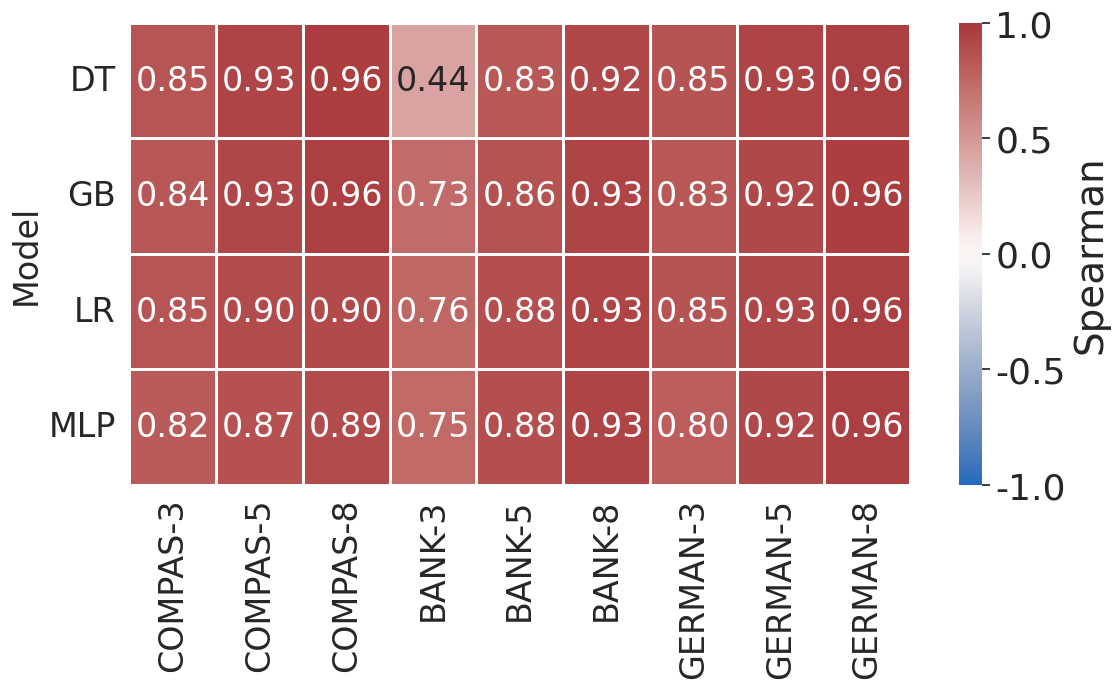

In [15]:
# --- Compact single-heatmap version (one column per dataset×k) ---

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

# Which ranker/method to plot (choose one)
SINGLE_METHOD_KEY = 'perso_xai'   # or 'autoxai' etc.
SINGLE_METHOD_LABEL = 'PersoXAI'  # label used in plot title / column naming

DATASET_SHORT = {
    'open_compas': 'COMPAS',
    'openml_bank_marketing': 'BANK',
    'openml_german_credit': 'GERMAN',
}

# --- Filter to single method ---
has_method = "method" in spearman_df.columns
if has_method:
    single_df = spearman_df[spearman_df["method"] == SINGLE_METHOD_KEY].copy()
else:
    single_df = spearman_df.copy()
if single_df.empty:
    if has_method:
        print(f"No rows found for method={SINGLE_METHOD_KEY}. Check method names in spearman_df['method'].unique().")
    else:
        print("No rows found in spearman_df. Check upstream loading/filters.")
else:
    # Datasets to include (preserve preferred order)
    datasets = [d for d in DATASETS_TO_PLOT if (single_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(single_df['dataset'].dropna().unique().tolist())

    # --- Build wide table: rows=models, cols=(dataset,k) ---
    wide = (
        single_df
        .pivot_table(
            index='model_label',
            columns=['dataset', 'k'],
            values='spearman',
            aggfunc='mean'
        )
    )

    # Enforce column order: dataset order × K order
    ordered_cols = []
    for d in datasets:
        for k in K_VALUES:
            col = (d, int(k))
            if col in wide.columns:
                ordered_cols.append(col)

    wide = wide.reindex(columns=pd.MultiIndex.from_tuples(ordered_cols, names=wide.columns.names))

    # Enforce model order (same idea as your original)
    present_models = set(single_df['model'])
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if model_key in present_models
    ]
    if model_order:
        wide = wide.reindex(model_order)

    # Flatten column names into compact strings: e.g., COMPAS-3
    def _col_label(d, k):
        d_short = DATASET_SHORT.get(d, DATASET_LABELS.get(d, _format_label(d)))
        return f"{d_short}-{int(k)}"

    wide.columns = [_col_label(d, k) for (d, k) in wide.columns]

    # --- Plot ---
    ncols = wide.shape[1]
    nrows = wide.shape[0]

    # fig_w = min(24, 1.87 * ncols)   # was 0.45
    # fig_h = min(10.4, 1.15 * nrows)

    fig_w = 1.40 * ncols   # was 0.45
    fig_h = 1.5 * nrows
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    mask = wide.isna()
    sns.heatmap(
        wide,
        annot=True,
        fmt='.2f',
        cmap='vlag',
        vmin=-1,
        vmax=1,
        mask=mask,
        cbar=True,
        cbar_kws={'label': 'Spearman'},
        ax=ax,

        # readability
        linewidths=0.8,
        linecolor='white',
        annot_kws={'fontsize': 24,},
    )

    cbar = ax.collections[0].colorbar
    cbar.set_label("Spearman", fontsize=28)
    cbar.ax.tick_params(labelsize=26)

    ax.set_xlabel('')
    ax.set_ylabel('Model', fontsize=24)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=24)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=24)

    # Optional separators:
    # 1) between each dataset block (every len(K_VALUES) columns)
    if len(K_VALUES) > 0:
        for x in range(len(K_VALUES), ncols, len(K_VALUES)):
            ax.axvline(x, color='white', linewidth=2)

    # 2) OR, if you prefer separators between each k (comment above + uncomment below)
    # for x in range(1, ncols):
    #     ax.axvline(x, color='white', linewidth=1.2)

    # Optional title
    # ax.set_title(
    #     f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): {SINGLE_METHOD_LABEL}"
    # )

    # fig.subplots_adjust(left=0.25, bottom=0.30)

    # fig.tight_layout()

    out_base = f"spearman_heatmap_compact_{SINGLE_METHOD_LABEL}_{PREFERENCE_ONLY_RUN_SUFFIX}"
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')

    # Save compact matrix values (easy to inspect)
    wide.to_csv(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}_values.csv")

    plt.show()
    plt.close(fig)
